In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from fbprophet import Prophet


In [2]:
# get matplotlib to recognize installed fonts
font_objects = mpl.font_manager.createFontList(mpl.font_manager.findSystemFonts()) # font_names = [f.name for f in font_objects]
mpl.font_manager.fontManager.ttflist = font_objects 
# sendgrid colors
sg_blue = '#1A82E2'
sg_slate = '#294661'
sg_mantis = '#18C96E'
sg_charting_colors = [sg_blue, sg_mantis, '#B71C1C', '#FF5722', '#FF9900', '#FDD835', '#4CB04F', '#8AC24A', '#CBDB39', '#303F9F', '#2196F3', '#00BCD4', '#00E5FF', '#7B1FA2', '#7C4DFF', '#880E4F', '#DEA7E8', '#FF4081', '#9E9E9E']
# sendgrid fonts
sg_fonts = ['Open Sans Light', 'Open Sans', 'Liberation Sans', 'Arial', 'sans-serif', 'DejaVu Sans']
# set colors and fonts
sns.set_style('ticks', {'axes.linewidth': 2., 'font.sans-serif': sg_fonts, 'font.family': sg_fonts})
sns.set_context('poster', font_scale=0.5, rc={"lines.linewidth": .5})
sns.set_palette(sg_charting_colors)
default_dpi = mpl.rcParamsDefault['figure.dpi']
mpl.rcParams['figure.dpi'] = default_dpi*2

INFO:matplotlib.font_manager:Could not open font file /usr/share/fonts/truetype/noto/NotoColorEmoji.ttf


In [3]:
# Load all processed counts
files = [
    "data.csv.gz",
]

dtypes = [
    ('timestamp', 'U'),
    ('temp', 'f')
]

filled = False
df = None
for file in files:
    frame = pd.read_csv(
        file,
        header=None,
        names=["timestamp", "temp"],
        dtype=dtypes,
        compression="gzip"
    )
    frame['timestamp'] = pd.to_datetime(frame['timestamp'],format='%Y%m%d%H%M')
    if not filled:
        df = frame
        filled = True
    else:
        df = df.append(frame)
df.set_index('timestamp', inplace=True)
df.head().append(df.tail())


,temp
timestamp,
1994-07-18 07:00:00,21.600000
1994-07-19 18:00:00,26.600000
1994-07-19 19:00:00,28.299999
1994-07-19 20:00:00,29.400000
1994-07-19 21:00:00,31.100000
2019-08-11 20:46:00,24.400000
2019-08-11 20:53:00,23.299999
2019-08-11 21:00:00,23.299999
2019-08-11 21:09:00,22.200001


In [4]:
# create days max resampling
days_max = df.resample('1440T').max().dropna()
days_max.head().append(days_max.tail())

,temp
timestamp,
1994-07-18,21.600000
1994-07-19,31.100000
1994-07-20,23.799999
1994-07-21,30.000000
1994-07-22,35.500000
2019-08-07,33.299999
2019-08-08,31.100000
2019-08-09,32.799999
2019-08-10,28.900000


In [5]:
# create days min resampling
days_min = df.resample('1440T').min().dropna()
days_min.head().append(days_min.tail())

,temp
timestamp,
1994-07-18,21.600000
1994-07-19,26.600000
1994-07-20,15.000000
1994-07-21,13.300000
1994-07-22,15.500000
2019-08-07,20.000000
2019-08-08,17.799999
2019-08-09,17.799999
2019-08-10,17.200001


In [6]:
# create days mean resampling
days_mean = df.resample('1440T').mean().dropna()
days_mean.head().append(days_mean.tail())

,temp
timestamp,
1994-07-18,21.600000
1994-07-19,29.133333
1994-07-20,18.773912
1994-07-21,20.608334
1994-07-22,23.956522
2019-08-07,26.096874
2019-08-08,21.047916
2019-08-09,23.574286
2019-08-10,24.100000


In [7]:
frame = days_max.reset_index()[['timestamp', 'temp']]
frame.columns = ['ds', 'y']

frame.head().append(frame.tail())

,ds,y
0,1994-07-18,21.600000
1,1994-07-19,31.100000
2,1994-07-20,23.799999
3,1994-07-21,30.000000
4,1994-07-22,35.500000
9019,2019-08-07,33.299999
9020,2019-08-08,31.100000
9021,2019-08-09,32.799999
9022,2019-08-10,28.900000
9023,2019-08-11,28.299999


In [8]:
# thanksgiving = pd.DataFrame({
#  'holiday': 'thanksgiving',
#  'ds': pd.to_datetime([
#      '2019-11-28',
#      '2018-11-22','2017-11-23', '2016-11-24', '2015-11-26']), #, '2014-11-27', '2013-11-28']),
#  'lower_window': 0,
#  'upper_window': 1,
#})

#blackfriday = pd.DataFrame({
#  'holiday': 'blackfriday',
#  'ds': pd.to_datetime([
#      '2019-11-29',
#      '2018-11-23', '2017-11-24', '2016-11-25', '2015-11-27']), #, '2014-11-28', '2013-11-29']),
#  'lower_window': 0,
#  'upper_window': 1,
#})

#holidays = pd.concat((blackfriday, thanksgiving))

m = Prophet(
    weekly_seasonality=False
#    yearly_seasonality=True,
#    growth='logistic',
#    #holidays=holidays,
#    mcmc_samples=0,
#    uncertainty_samples=len(frame),
#    seasonality_prior_scale=10.0,
#    holidays_prior_scale=10.0,
#    changepoint_prior_scale=0.05,
#    interval_width=0.99,
#    seasonality_mode='multiplicative'
)
m.fit(frame)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [9]:
future = m.make_future_dataframe(periods=367)
future.head().append(future.tail())

,ds
0,1994-07-18
1,1994-07-19
2,1994-07-20
3,1994-07-21
4,1994-07-22
9386,2020-08-08
9387,2020-08-09
9388,2020-08-10
9389,2020-08-11
9390,2020-08-12


In [10]:
forecast = m.predict(future)
forecast.head().append(forecast.tail())

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,yhat
0,1994-07-18,17.252186,17.252186,17.252186,23.476781,38.049877,13.756204,13.756204,13.756204,0.0,0.0,0.0,13.756204,13.756204,13.756204,31.008390
1,1994-07-19,17.252790,17.252790,17.252790,23.509650,38.512029,13.714524,13.714524,13.714524,0.0,0.0,0.0,13.714524,13.714524,13.714524,30.967313
2,1994-07-20,17.253394,17.253394,17.253394,23.725692,38.414421,13.662282,13.662282,13.662282,0.0,0.0,0.0,13.662282,13.662282,13.662282,30.915676
3,1994-07-21,17.253997,17.253997,17.253997,22.825349,38.087673,13.600291,13.600291,13.600291,0.0,0.0,0.0,13.600291,13.600291,13.600291,30.854288
4,1994-07-22,17.254601,17.254601,17.254601,23.602266,38.175034,13.529464,13.529464,13.529464,0.0,0.0,0.0,13.529464,13.529464,13.529464,30.784065
9386,2020-08-08,19.287527,19.281504,19.293270,23.208425,39.052806,12.062102,12.062102,12.062102,0.0,0.0,0.0,12.062102,12.062102,12.062102,31.349630
9387,2020-08-09,19.287621,19.281575,19.293390,23.813631,38.129120,12.023633,12.023633,12.023633,0.0,0.0,0.0,12.023633,12.023633,12.023633,31.311253
9388,2020-08-10,19.287714,19.281647,19.293510,24.074507,39.017579,11.992721,11.992721,11.992721,0.0,0.0,0.0,11.992721,11.992721,11.992721,31.280435
9389,2020-08-11,19.287807,19.281720,19.293630,23.692253,38.906376,11.968925,11.968925,11.968925,0.0,0.0,0.0,11.968925,11.968925,11.968925,31.256732
9390,2020-08-12,19.287900,19.281793,19.293750,24.161300,38.827914,11.951621,11.951621,11.951621,0.0,0.0,0.0,11.951621,11.951621,11.951621,31.239521


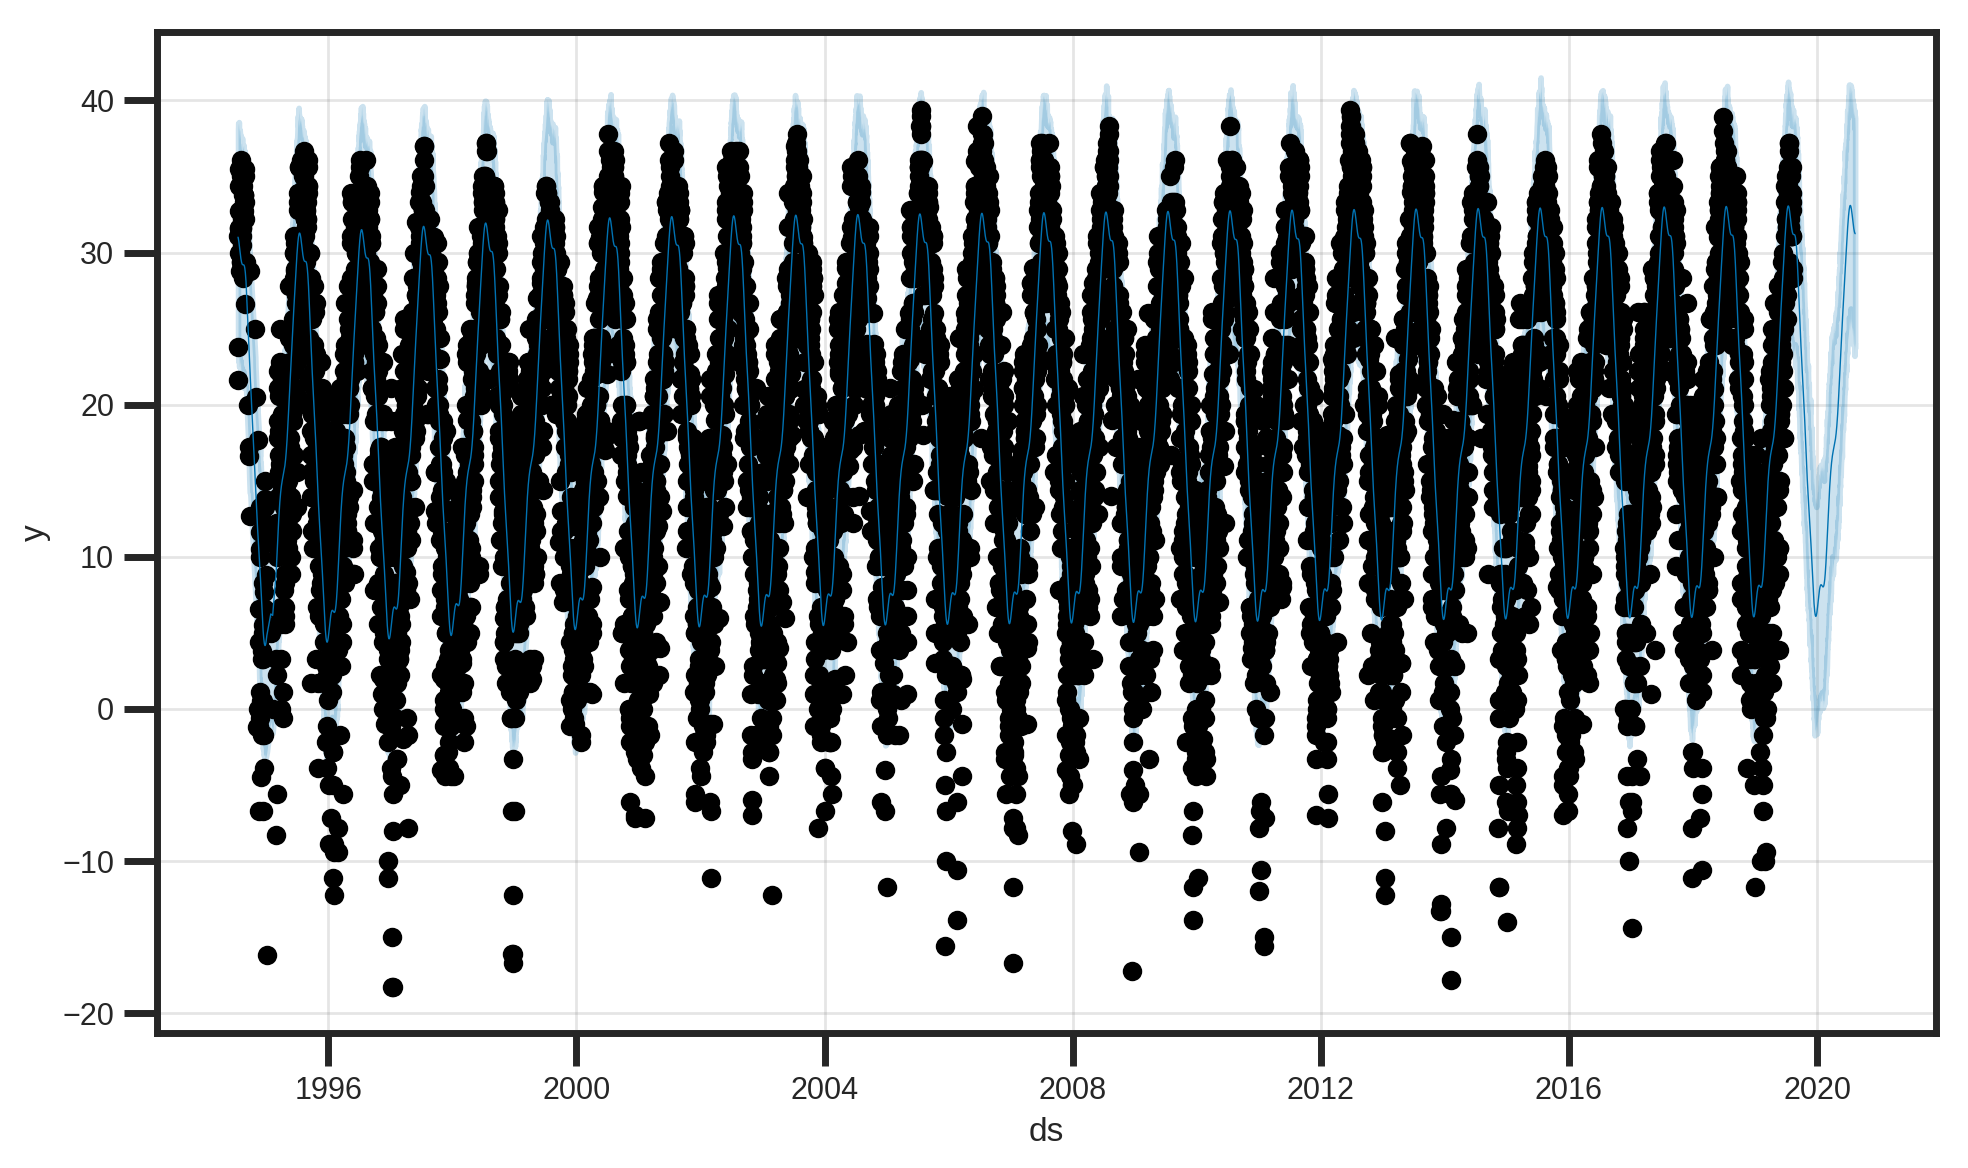

In [11]:
pd.plotting.register_matplotlib_converters()
fig = m.plot(forecast)

<Figure size 2000x1200 with 0 Axes>

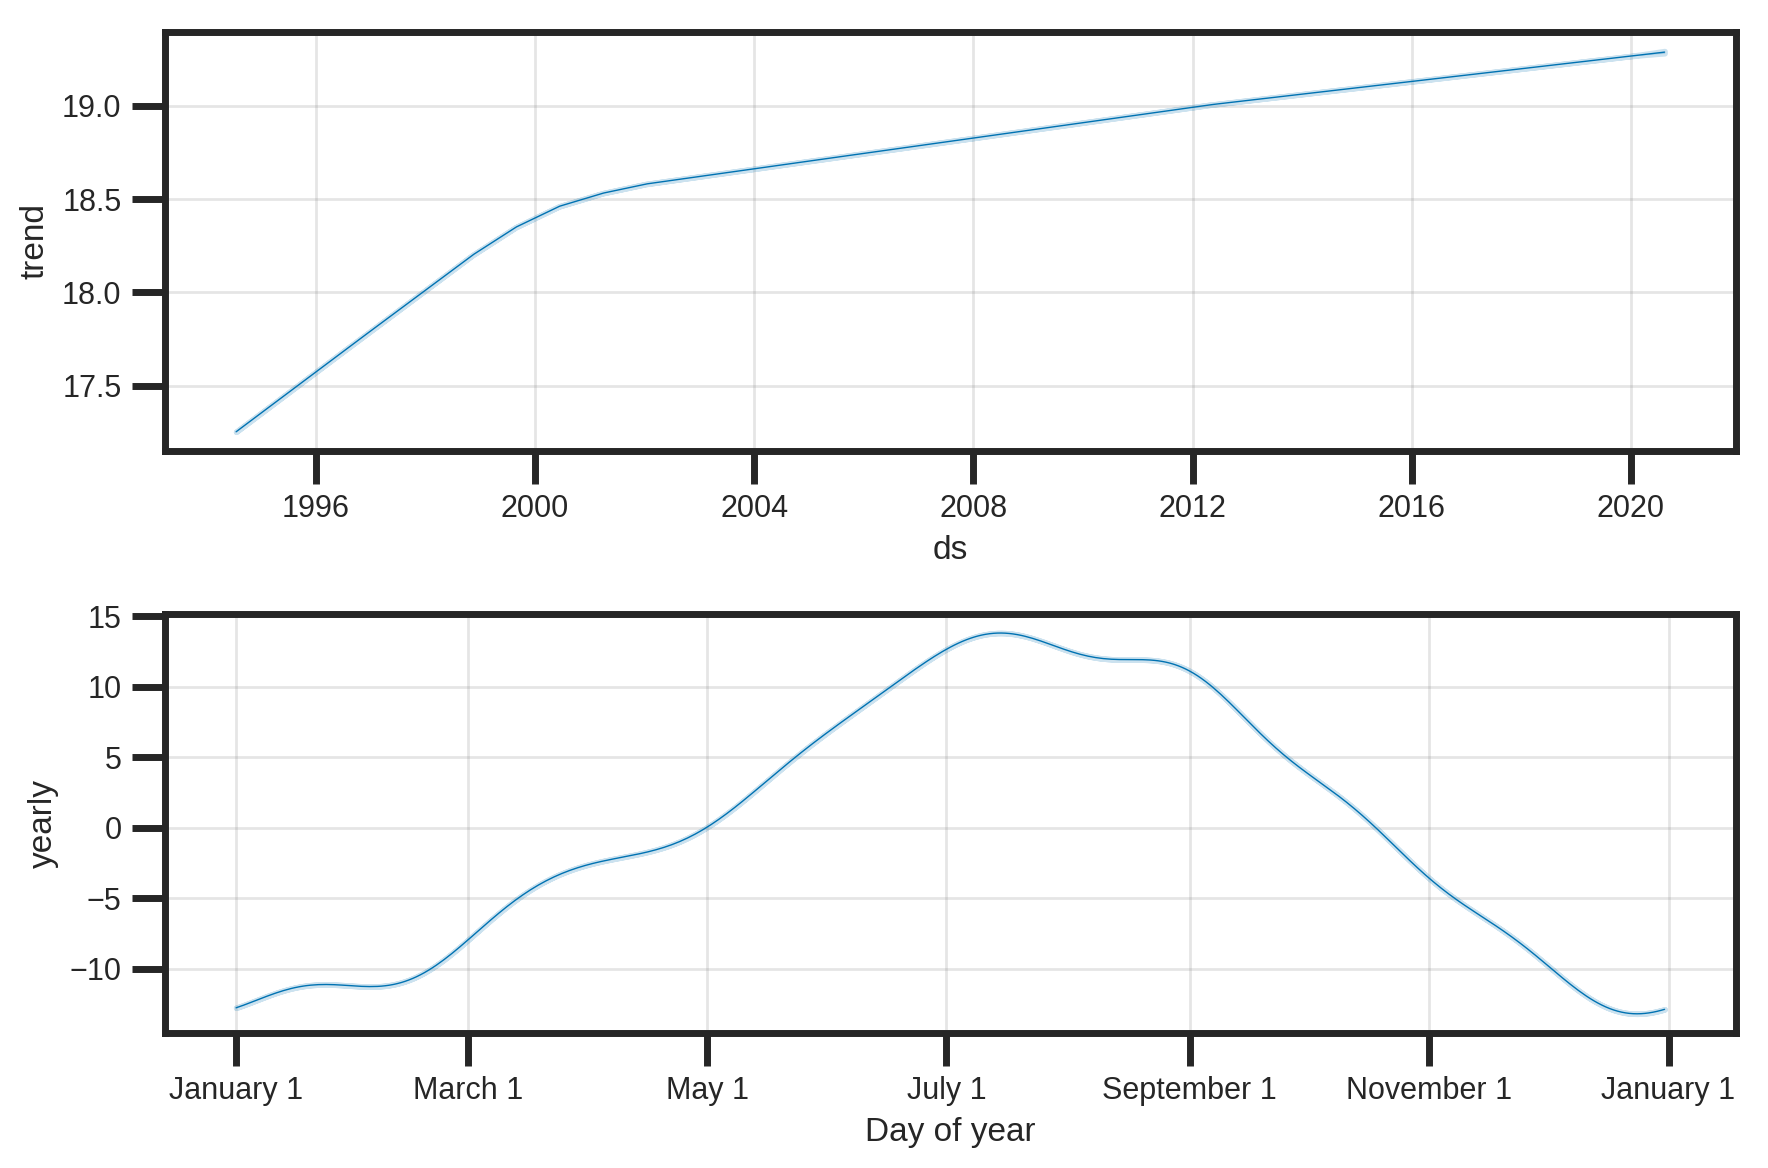

In [13]:
deltas = (([100]*len(m.changepoints)+m.params['delta'].mean(0))/100)**12-[1]*len(m.changepoints)
fig = plt.figure(facecolor='w', figsize=(10, 6))
fig.tight_layout()
yoy_rates = [(a - b)/b for a, b in zip(forecast['trend'].tail(1000), forecast['trend'].tail(1365).head(1000))]
m.plot_components(forecast,plot_cap=False);
